In [5]:
import os
# Find the latest version of spark 3.x  from https://downloads.apache.org/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.5.4'
spark_version = 'spark-3.5.4'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

# Start a SparkSession
import findspark
findspark.init()

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,315 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,677 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:10 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,609 kB]
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://archive.ubuntu.com/ubunt

In [6]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("ReadParquet").getOrCreate()

In [7]:
from google.colab import drive
drive.mount('/content/drive')

# Load the Parquet file from Google Drive
file_path = "/content/drive/My Drive/TeamFiles/cleaned_data.parquet"
cleaned_df = spark.read.parquet(file_path)
cleaned_df.show(5)

Mounted at /content/drive
+---+----------+----+-------------+----------+-----------------+-------------+---------------------------+----+-----+---+
|FSA|      DATE|HOUR|CUSTOMER_TYPE|PRICE_PLAN|TOTAL_CONSUMPTION|PREMISE_COUNT|AVG_CONSUMPTION_PER_PREMISE|YEAR|MONTH|DAY|
+---+----------+----+-------------+----------+-----------------+-------------+---------------------------+----+-----+---+
|M1V|2024-07-01|   1|    SGS <50kW|    Tiered|           3125.6|         1716|         1.8214452214452215|2024|    7|  1|
|L7M|2024-07-01|   1|    SGS <50kW|       TOU|           1563.8|          683|         2.2896046852122987|2024|    7|  1|
|L9W|2024-07-01|   1|  Residential|    Tiered|            925.0|         1232|         0.7508116883116883|2024|    7|  1|
|M2J|2024-07-01|   1|    SGS <50kW|    Tiered|            598.0|          267|         2.2397003745318353|2024|    7|  1|
|K2C|2024-07-01|   1|  Residential|       TOU|           5095.2|         7714|         0.6605133523463832|2024|    7|  1

Linear Regression RMSE: 2602.75


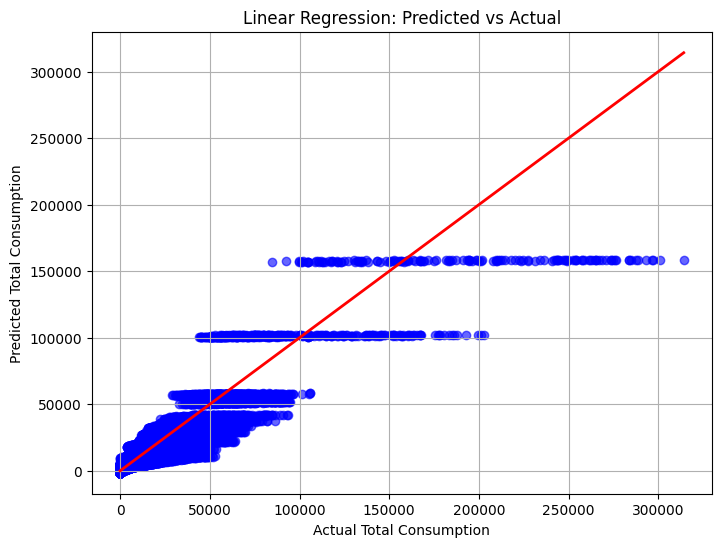

In [5]:
# Linear Regression Model
# Feature Engineering for Linear Regression
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt

# Encode categorical columns
customer_type_indexer = StringIndexer(inputCol="CUSTOMER_TYPE", outputCol="CUSTOMER_TYPE_INDEX")
price_plan_indexer = StringIndexer(inputCol="PRICE_PLAN", outputCol="PRICE_PLAN_INDEX")

# Define feature columns
feature_columns = [
    "HOUR", "PREMISE_COUNT", "AVG_CONSUMPTION_PER_PREMISE",
    "CUSTOMER_TYPE_INDEX", "PRICE_PLAN_INDEX", "YEAR", "MONTH", "DAY"
]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Create a pipeline
pipeline = Pipeline(stages=[customer_type_indexer, price_plan_indexer, assembler])

# Apply the pipeline
prepared_data = pipeline.fit(cleaned_df).transform(cleaned_df)

# Split Data
train_data, test_data = prepared_data.randomSplit([0.8, 0.2], seed=42)

# Train Linear Regression
lr = LinearRegression(featuresCol="features", labelCol="TOTAL_CONSUMPTION")
lr_model = lr.fit(train_data)

# Make Predictions
lr_predictions = lr_model.transform(test_data)

# Evaluate Model
lr_evaluator = RegressionEvaluator(
    labelCol="TOTAL_CONSUMPTION", predictionCol="prediction", metricName="rmse"
)
lr_rmse = lr_evaluator.evaluate(lr_predictions)
print(f"Linear Regression RMSE: {lr_rmse:.2f}")

# Plot Predictions
lr_pred_df = lr_predictions.select("TOTAL_CONSUMPTION", "prediction").toPandas()

plt.figure(figsize=(8, 6))
plt.scatter(lr_pred_df["TOTAL_CONSUMPTION"], lr_pred_df["prediction"], alpha=0.6, color="blue")
plt.plot([lr_pred_df["TOTAL_CONSUMPTION"].min(), lr_pred_df["TOTAL_CONSUMPTION"].max()],
         [lr_pred_df["TOTAL_CONSUMPTION"].min(), lr_pred_df["TOTAL_CONSUMPTION"].max()],
         color="red", linewidth=2)
plt.title("Linear Regression: Predicted vs Actual")
plt.xlabel("Actual Total Consumption")
plt.ylabel("Predicted Total Consumption")
plt.grid()
plt.show()



Random Forest RMSE: 3290.05


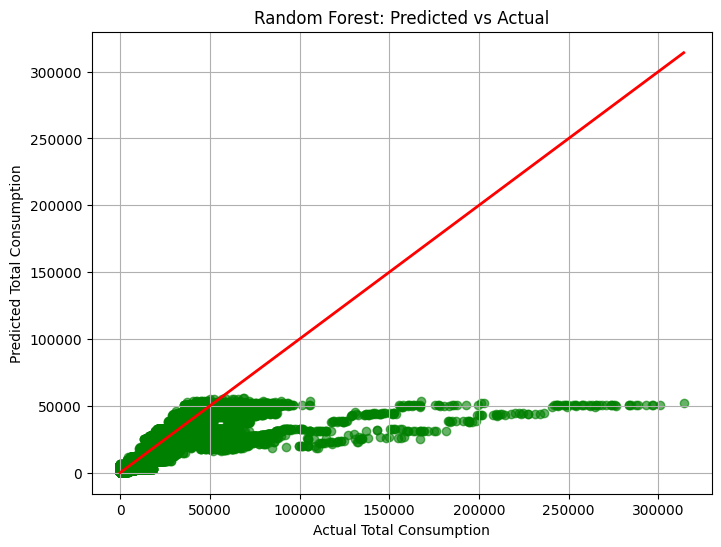

In [6]:
# Random Forest Model
# Feature Engineering for Random Forest
from pyspark.ml.regression import RandomForestRegressor

# Encode categorical columns
customer_type_indexer = StringIndexer(inputCol="CUSTOMER_TYPE", outputCol="CUSTOMER_TYPE_INDEX")
price_plan_indexer = StringIndexer(inputCol="PRICE_PLAN", outputCol="PRICE_PLAN_INDEX")

# Define feature columns
feature_columns = [
    "HOUR", "PREMISE_COUNT", "AVG_CONSUMPTION_PER_PREMISE",
    "CUSTOMER_TYPE_INDEX", "PRICE_PLAN_INDEX", "YEAR", "MONTH", "DAY"
]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Create a pipeline
pipeline = Pipeline(stages=[customer_type_indexer, price_plan_indexer, assembler])

# Apply the pipeline
prepared_data = pipeline.fit(cleaned_df).transform(cleaned_df)

# Split Data
train_data, test_data = prepared_data.randomSplit([0.8, 0.2], seed=42)

# Train Random Forest
rf = RandomForestRegressor(featuresCol="features", labelCol="TOTAL_CONSUMPTION")
rf_model = rf.fit(train_data)

# Make Predictions
rf_predictions = rf_model.transform(test_data)

# Evaluate Model
rf_evaluator = RegressionEvaluator(
    labelCol="TOTAL_CONSUMPTION", predictionCol="prediction", metricName="rmse"
)
rf_rmse = rf_evaluator.evaluate(rf_predictions)
print(f"Random Forest RMSE: {rf_rmse:.2f}")

# Plot Predictions
rf_pred_df = rf_predictions.select("TOTAL_CONSUMPTION", "prediction").toPandas()

plt.figure(figsize=(8, 6))
plt.scatter(rf_pred_df["TOTAL_CONSUMPTION"], rf_pred_df["prediction"], alpha=0.6, color="green")
plt.plot([rf_pred_df["TOTAL_CONSUMPTION"].min(), rf_pred_df["TOTAL_CONSUMPTION"].max()],
         [rf_pred_df["TOTAL_CONSUMPTION"].min(), rf_pred_df["TOTAL_CONSUMPTION"].max()],
         color="red", linewidth=2)
plt.title("Random Forest: Predicted vs Actual")
plt.xlabel("Actual Total Consumption")
plt.ylabel("Predicted Total Consumption")
plt.grid()
plt.show()


In [ ]:
# Install required libraries
!pip install keras-tuner

In [8]:
# Spark Optimized Neural Network Workflow

# Import Required Libraries
import numpy as np
import tensorflow as tf
import keras_tuner as kt
from pyspark.ml.feature import StringIndexer, VectorAssembler, MinMaxScaler
from pyspark.ml import Pipeline

# Prepare Data in Spark
# Encode categorical columns
customer_type_indexer = StringIndexer(inputCol="CUSTOMER_TYPE", outputCol="CUSTOMER_TYPE_INDEX")
price_plan_indexer = StringIndexer(inputCol="PRICE_PLAN", outputCol="PRICE_PLAN_INDEX")

# Assemble feature columns
feature_columns = [
    "HOUR", "PREMISE_COUNT", "AVG_CONSUMPTION_PER_PREMISE",
    "CUSTOMER_TYPE_INDEX", "PRICE_PLAN_INDEX", "YEAR", "MONTH", "DAY"
]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Normalize the features using MinMaxScaler
scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")

# Create a pipeline
pipeline = Pipeline(stages=[customer_type_indexer, price_plan_indexer, assembler, scaler])

# Apply transformations
prepared_data = pipeline.fit(cleaned_df).transform(cleaned_df)

# Select necessary columns
final_data = prepared_data.select("scaled_features", "TOTAL_CONSUMPTION")

# Train-Test Split in Spark
train_data, test_data = final_data.randomSplit([0.8, 0.2], seed=42)

# Convert Spark DataFrame to NumPy
train_pandas = train_data.toPandas()
test_pandas = test_data.toPandas()

X_train = np.array(train_pandas["scaled_features"].tolist())
y_train = train_pandas["TOTAL_CONSUMPTION"]
X_test = np.array(test_pandas["scaled_features"].tolist())
y_test = test_pandas["TOTAL_CONSUMPTION"]

# Define Neural Network Model for Hyperparameter Tuning
def create_model(hp):
    nn_model = tf.keras.models.Sequential()

    # Allow kerastuner to decide which activation function to use in hidden layers
    activation = hp.Choice('activation', ['relu', 'tanh', 'sigmoid'])

    # Allow kerastuner to decide number of neurons in first layer
    nn_model.add(tf.keras.layers.Dense(
        units=hp.Int('first_units', min_value=16, max_value=256, step=32),
        activation=activation,
        input_dim=X_train.shape[1]
    ))

    # Allow kerastuner to decide number of hidden layers and neurons
    for i in range(hp.Int('num_layers', 1, 5)):
        nn_model.add(tf.keras.layers.Dense(
            units=hp.Int(f'units_{i}', min_value=16, max_value=256, step=32),
            activation=activation
        ))

    # Output layer
    nn_model.add(tf.keras.layers.Dense(units=1))

    # Compile the model
    nn_model.compile(
        optimizer='adam',
        loss='mse',
        metrics=['mae']
    )

    return nn_model

# Use Keras Tuner for Hyperparameter Optimization
tuner = kt.Hyperband(
    create_model,
    objective="val_mae",
    max_epochs=20,
    factor=3,
    directory="tuning_logs",
    project_name="spark_nn_tuning"
)

# Train Neural Network with Hyperparameter Tuning
tuner.search(X_train, y_train, epochs=20, validation_data=(X_test, y_test))

# Evaluate Best Model
best_hyper = tuner.get_best_hyperparameters(1)[0]
print("Best Hyperparameters:", best_hyper.values)

# Retrieve and evaluate the best model
best_model = tuner.get_best_models(1)[0]
model_loss, model_mae = best_model.evaluate(X_test, y_test, verbose=2)

print(f"Best Model Loss (MSE): {model_loss:.2f}")
print(f"Best Model MAE: {model_mae:.2f}")

# Make Predictions
nn_predictions = best_model.predict(X_test)

# Plot Predicted vs Actual
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test, nn_predictions, alpha=0.6, color="purple")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red", linewidth=2)
plt.title("Neural Network: Predicted vs Actual")
plt.xlabel("Actual Total Consumption")
plt.ylabel("Predicted Total Consumption")
plt.grid()
plt.show()

# Plot Training Loss and MAE Over Epochs
history = best_model.history.history  # Get training history

# Loss Plot
plt.figure(figsize=(8, 6))
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title("Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Mean Squared Error (MSE)")
plt.legend()
plt.grid()
plt.show()

# MAE Plot
plt.figure(figsize=(8, 6))
plt.plot(history['mae'], label='Training MAE')
plt.plot(history['val_mae'], label='Validation MAE')
plt.title("MAE Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Error (MAE)")
plt.legend()
plt.grid()
plt.show()


Trial 17 Complete [02h 01m 58s]
val_mae: 41.10798645019531

Best val_mae So Far: 39.03237533569336
Total elapsed time: 08h 38m 48s

Search: Running Trial #18

Value             |Best Value So Far |Hyperparameter
relu              |relu              |activation
80                |144               |first_units
2                 |5                 |num_layers
112               |240               |units_0
20                |7                 |tuner/epochs
7                 |3                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
2                 |1                 |tuner/round
16                |48                |units_1
0014              |0003              |tuner/trial_id
240               |240               |units_2
144               |176               |units_3
112               |208               |units_4



/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 8/20
 57863/104491 ━━━━━━━━━━━━━━━━━━━━ 1:58 3ms/step - loss: 20611.2695 - mae: 67.0546

KeyboardInterrupt: 

In [9]:
# Save the best Model
import tensorflow as tf

# Get the best model so far
best_model = tuner.get_best_models(num_models=1)[0]

# Define the save path
model_save_path = "/content/drive/My Drive/TeamFiles/best_neural_network.h5"

# Save the model
best_model.save(model_save_path)
print(f"✅ Model saved successfully at {model_save_path}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


✅ Model saved successfully at /content/drive/My Drive/TeamFiles/best_neural_network.h5


In [10]:
# Save the best Hyperparameter
import json

# Get the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Save the hyperparameters as a JSON file
hyperparameter_path = "/content/drive/My Drive/TeamFiles/best_hyperparameters.json"
with open(hyperparameter_path, "w") as f:
    json.dump(best_hyperparameters.values, f)

print(f"✅ Hyperparameters saved successfully at {hyperparameter_path}")


✅ Hyperparameters saved successfully at /content/drive/My Drive/TeamFiles/best_hyperparameters.json
